In [2]:
#Loading the original tables into dataframes
#df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)
#df_vehicle=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1979-2021.csv', sep=',', header=0)
#df_casualty=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1979-2021.csv', sep=',', header=0)

In [2]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from python.data_cleaning import prepare_data_for_groupby
from python.grouped_data import data_for_analysis
from python import mlmodel

2022-12-08 15:36:53.677778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:36:54.045061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 15:36:54.045085: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 15:37:00.224736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
#Filtering the dataframes to get dta from 1999 only
#df_accident_1999=df_accident[df_accident['accident_year']>=1999]
#df_vehicle_1999=df_vehicle[df_vehicle['accident_year']>=1999]
#df_casualty_1999=df_casualty[df_casualty['accident_year']>=1999]

In [3]:
#Exporting the data from 1999 as csv files --> the new raw data files
#df_accident_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv')
#df_vehicle_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1999-2021.csv')
#df_casualty_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1999-2021.csv')

In [3]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)
df_accidents.head()

/tmp/ipykernel_2417/1322138315.py:1: DtypeWarning: Columns (1,3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
4883216,1999010SU0945,1999,010SU0945,519490.0,203300.0,-0.271752,51.715661,1,3,1,...,0,1,4,1,0,0,2,1,1,E01023583
4883217,1999010SU0946,1999,010SU0946,521740.0,201070.0,-0.239977,51.695136,1,3,2,...,0,6,4,1,0,0,2,1,1,E01023584
4883218,1999010SU0947,1999,010SU0947,519610.0,203240.0,-0.270037,51.715096,1,3,2,...,0,4,1,2,0,0,2,1,1,E01023583
4883219,1999010SU0948,1999,010SU0948,520090.0,202830.0,-0.263233,51.711309,1,2,2,...,0,6,1,1,0,0,2,1,1,E01023583
4883220,1999010SU0949,1999,010SU0949,522640.0,200320.0,-0.227225,51.688200,1,3,4,...,0,1,1,2,0,0,2,1,1,E01023584


In [4]:
test=prepare_data_for_groupby(df_accidents,6)

In [5]:
test_data=data_for_analysis(test,granularity='W')
test_data.head(52)

,Accidents
date,
1999-01-04,1586
1999-01-11,4623
1999-01-18,5000
1999-01-25,4589
1999-02-01,4137
1999-02-08,3986
1999-02-15,4320
1999-02-22,3902
1999-03-01,4321


In [6]:
test_data.shape

(1201, 1)

In [7]:
hashes=pd.DataFrame(test[['geohash','accident_year']].groupby('geohash').count())
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)
hashes.shape


(184578, 1)

In [8]:
hashes.describe()

,Accidents
count,184578.000000
mean,20.676852
std,57.175713
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,2045.000000


In [245]:
hashes[hashes['Accidents']>=1500]

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744
gcpvh3,1724
gcpvhf,1670
gcpvh9,1637
gcpvjh,1505


In [10]:
#Isolating the square where there are more accidents
max_square=hashes[hashes['Accidents']==hashes.Accidents.max()].index[0]
max_square

'gcpvj0'

In [11]:
#Filtering the data for the max_square
test_max_square=test[test['geohash']==max_square]
test_max_square.shape

(2045, 13)

In [244]:
test_data_max_square=data_for_analysis(test_max_square,'W')
test_data_max_square['Accidents'].unique()

array([1, 4, 3, 5, 2, 7, 6, 8, 9, 0])

In [246]:
FOLD_LENGTH=416 #each fold spans over 8 years
FOLD_STRIDE=52 #we have a fold every 1 year
INPUT_LENGTH=10 #every X_i sequence is 10 weeks long
TRAIN_TEST_RATIO=.80 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=10 #we want to predict the number of accidents in the next 10 weeks (y_i length)
SEQUENCE_STRIDE = 1

In [247]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for hash in hashes[hashes['Accidents']>=1500].index:
    data=test[test['geohash']==hash]
    data_series=data_for_analysis(data,'W')
    folds=mlmodel.get_folds(data_series,FOLD_LENGTH,FOLD_STRIDE)
    for fold in folds:
        (fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
        X_train_fold, y_train_fold = mlmodel.get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test_fold, y_test_fold = mlmodel.get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)   
        X_train.append(X_train_fold)
        X_test.append(X_test_fold)
        y_train.append(y_train_fold)
        y_test.append(y_test_fold)
np.array(X_test).shape, np.array(y_train).shape

((160, 74, 10, 1), (160, 314, 10, 1))

In [248]:
X_train_all_hashes=np.array(X_train[0])
X_test_all_hashes=np.array(X_test[0])
y_train_all_hashes=np.array(y_train[0])
y_test_all_hashes=np.array(y_test[0])

for i in range(1,np.array(X_train).shape[0]):
    X_train_all_hashes=np.vstack((X_train_all_hashes,X_train[i]))
    y_train_all_hashes=np.vstack((y_train_all_hashes,y_train[i]))
    
for i in range(1,np.array(X_test).shape[0]):
    X_test_all_hashes=np.vstack((X_test_all_hashes,X_test[i]))
    y_test_all_hashes=np.vstack((y_test_all_hashes,y_test[i]))

In [249]:
X_train_all_hashes.shape

(50240, 10, 1)

In [259]:
model = mlmodel.init_simple_model(X_train_all_hashes)
model.summary()

Model: "sequential_241"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 64)            4224      
                                                                 
 dense_380 (Dense)           (None, 10, 1)             65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [260]:
model, history = mlmodel.fit_model(model,X_train_all_hashes,y_train_all_hashes)

Epoch 1/100
1099/1099 [==============================] - 13s 11ms/step - loss: 1.6749 - mae: 1.0186 - val_loss: 1.4388 - val_mae: 0.9076
Epoch 2/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6103 - mae: 1.0074 - val_loss: 1.4353 - val_mae: 0.9088
Epoch 3/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6108 - mae: 1.0079 - val_loss: 1.4288 - val_mae: 0.9066
Epoch 4/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6094 - mae: 1.0072 - val_loss: 1.4261 - val_mae: 0.9077
Epoch 5/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6113 - mae: 1.0072 - val_loss: 1.4239 - val_mae: 0.9063
Epoch 6/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6121 - mae: 1.0078 - val_loss: 1.4149 - val_mae: 0.9076
Epoch 7/100
1099/1099 [==============================] - 11s 10ms/step - loss: 1.6111 - mae: 1.0077 - val_loss: 1.4161 - val_mae: 0.9056
Epoch 8/100
1099/1099 [==================

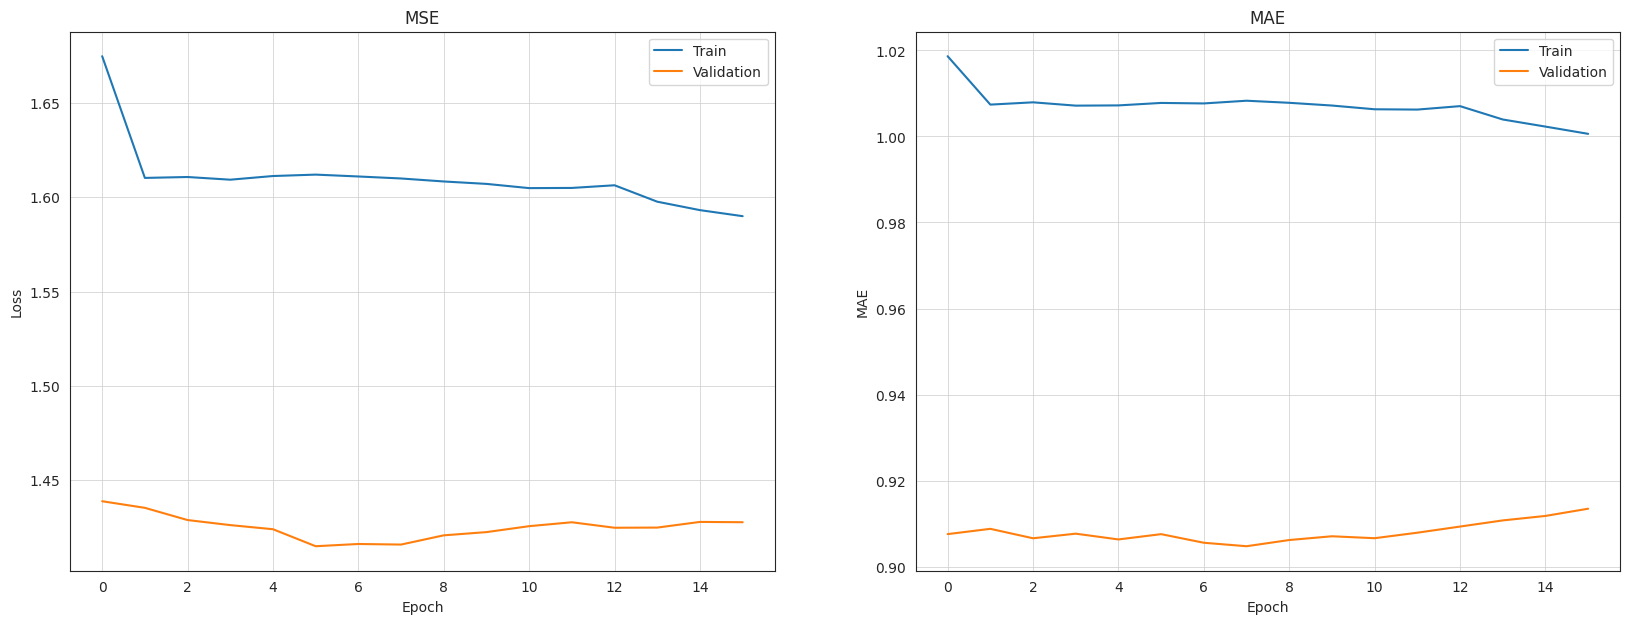

In [261]:
mlmodel.plot_history(history);

In [262]:
y_pred1=model.predict(X_test_all_hashes)
y_bas_pred1=baseline_model.predict(X_test_all_hashes)

370/370 [==============================] - 1s 2ms/step


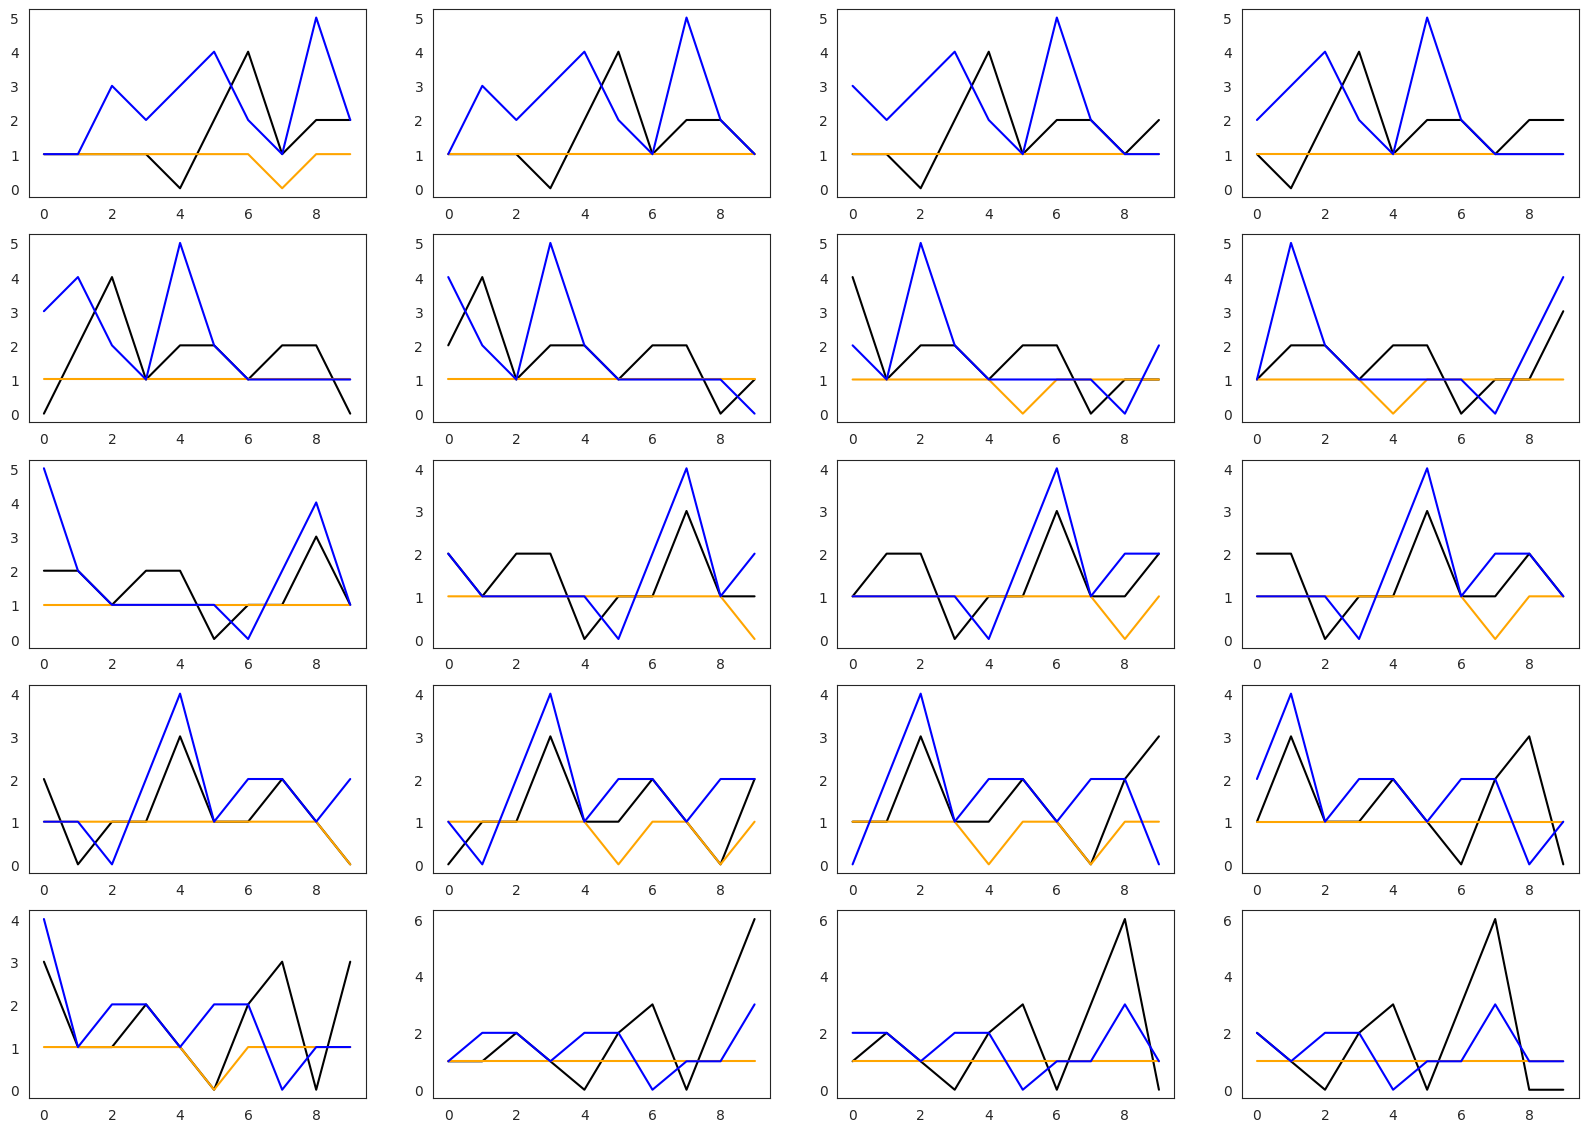

In [263]:
import seaborn as sns
plt.figure(figsize=(20, 20))
for id in range(0,20):
    plt.subplot(7,4,id+1)
    df_test=pd.DataFrame(y_test_all_hashes[id])
    df_pred=pd.DataFrame(y_pred1[id].astype(int))
    df_bas_pred=pd.DataFrame(y_bas_pred1[id])
    plt.plot(df_test[0],c='black',label='test set')
    plt.plot(df_pred[0],c='orange',label='lstm prediction')
    plt.plot(df_bas_pred[0],c='blue',label='baseline prediction')
plt.show()

In [14]:
time_series=data_for_analysis(test,'W')

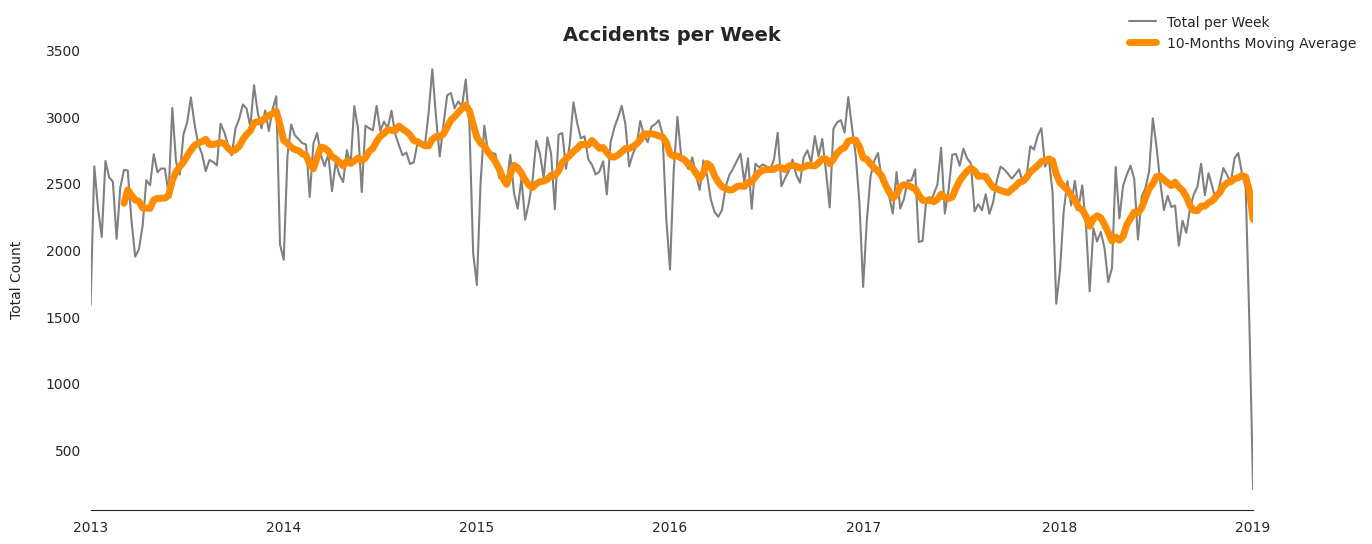

In [70]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,6))

# plot
test[(test['accident_year']<=2018) & (test['accident_year']>=2013)].set_index('date').resample('W').size().plot(label='Total per Week', color='grey', ax=ax)
test[(test['accident_year']<=2018) & (test['accident_year']>=2013)].set_index('date').resample('W').size().rolling(window=10).mean()\
                           .plot(color='darkorange', linewidth=5, label='10-Months Moving Average', ax=ax)

ax.set_title('Accidents per Week', fontsize=14, fontweight='bold')
ax.set(ylabel='Total Count\n', xlabel='')
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False);

In [217]:
folds=mlmodel.get_folds(test_data_max_square,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(16, 416, 1)

In [218]:
fold1=folds[10]

In [219]:
(fold1_train, fold1_test) = mlmodel.train_test_split(fold1, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold1_train.shape

(333, 1)

In [231]:
X_train1, y_train1 = mlmodel.get_X_y_strides(fold1_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test1, y_test1 = mlmodel.get_X_y_strides(fold1_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [221]:
X_train1

(314, 10, 1)

In [232]:
y_train1.shape

(314, 10, 1)

In [235]:
model = mlmodel.init_simple_model(X_train1)
model.summary()

Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_206 (LSTM)             (None, 10, 64)            16896     
                                                                 
 dense_378 (Dense)           (None, 10, 1)             65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [236]:
model, history = mlmodel.fit_model(model,X_train1,y_train1)

Epoch 1/500
7/7 [==============================] - 5s 147ms/step - loss: 3.4997 - mae: 1.4316 - val_loss: 2.7999 - val_mae: 1.2816
Epoch 2/500
7/7 [==============================] - 0s 22ms/step - loss: 2.6772 - mae: 1.2125 - val_loss: 2.2087 - val_mae: 1.1303
Epoch 3/500
7/7 [==============================] - 0s 22ms/step - loss: 2.2447 - mae: 1.1172 - val_loss: 2.1282 - val_mae: 1.1449
Epoch 4/500
7/7 [==============================] - 0s 22ms/step - loss: 2.1988 - mae: 1.1462 - val_loss: 2.1029 - val_mae: 1.1467
Epoch 5/500
7/7 [==============================] - 0s 23ms/step - loss: 2.1330 - mae: 1.1266 - val_loss: 1.9919 - val_mae: 1.1032
Epoch 6/500
7/7 [==============================] - 0s 27ms/step - loss: 2.0752 - mae: 1.0972 - val_loss: 1.9440 - val_mae: 1.0858
Epoch 7/500
7/7 [==============================] - 0s 26ms/step - loss: 2.0440 - mae: 1.0839 - val_loss: 1.9149 - val_mae: 1.0791
Epoch 8/500
7/7 [==============================] - 0s 21ms/step - loss: 2.0126 - mae: 1.0

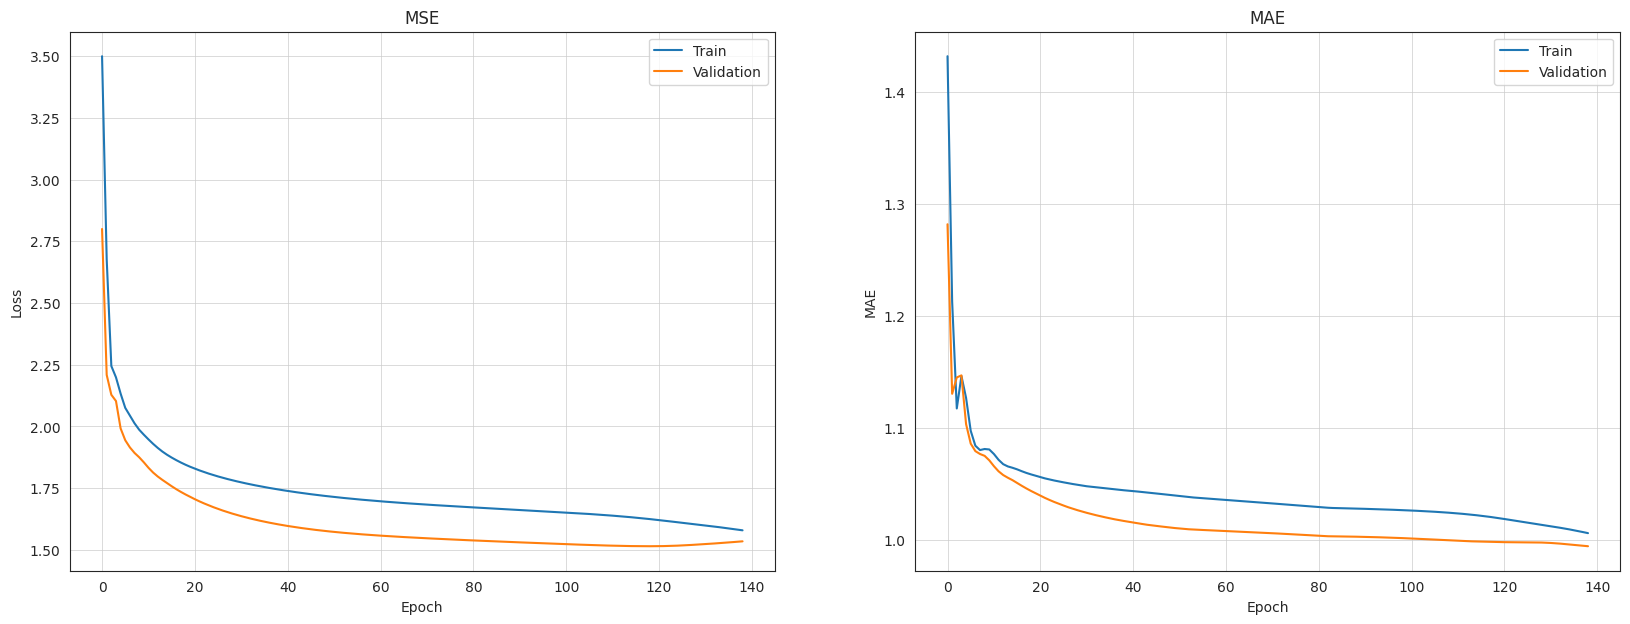

In [237]:
mlmodel.plot_history(history);

In [193]:
res=model.evaluate(X_test1,y_test1)

2/2 [==============================] - 0s 12ms/step - loss: 1.4679 - mae: 0.9873


In [170]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test1, y_test1)

2/2 [==============================] - 0s 6ms/step - loss: 4.5349 - mae: 1.4977


In [194]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 0.99 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 34.08 %


In [238]:
y_pred1=model.predict(X_test1)
y_bas_pred1=baseline_model.predict(X_test1)

3/3 [==============================] - 0s 2ms/step


In [173]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(test_data_max_square,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

20
--------------------------------------------------
MAE baseline fold n°0 = 1.5
MAE LSTM fold n°0 = 1.08
Improvement over baseline: 27.56 % 

--------------------------------------------------
MAE baseline fold n°1 = 1.65
MAE LSTM fold n°1 = 1.23
Improvement over baseline: 25.83 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.67
MAE LSTM fold n°2 = 1.15
Improvement over baseline: 31.45 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.27
MAE LSTM fold n°3 = 0.98
Improvement over baseline: 22.51 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.27
MAE LSTM fold n°4 = 1.11
Improvement over baseline: 12.81 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.11
MAE LSTM fold n°5 = 1.11
Improvement over baseline: 0.71 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.6
MAE LSTM fold n°6 = 1.28
Improvement over baseline: 20.32 % 

------

In [174]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 12.0%


In [175]:
np.mean(np.array(mae_lstms))

1.1491490989923476

In [176]:
np.mean(np.array(mae_baselines))

1.3159302294254303

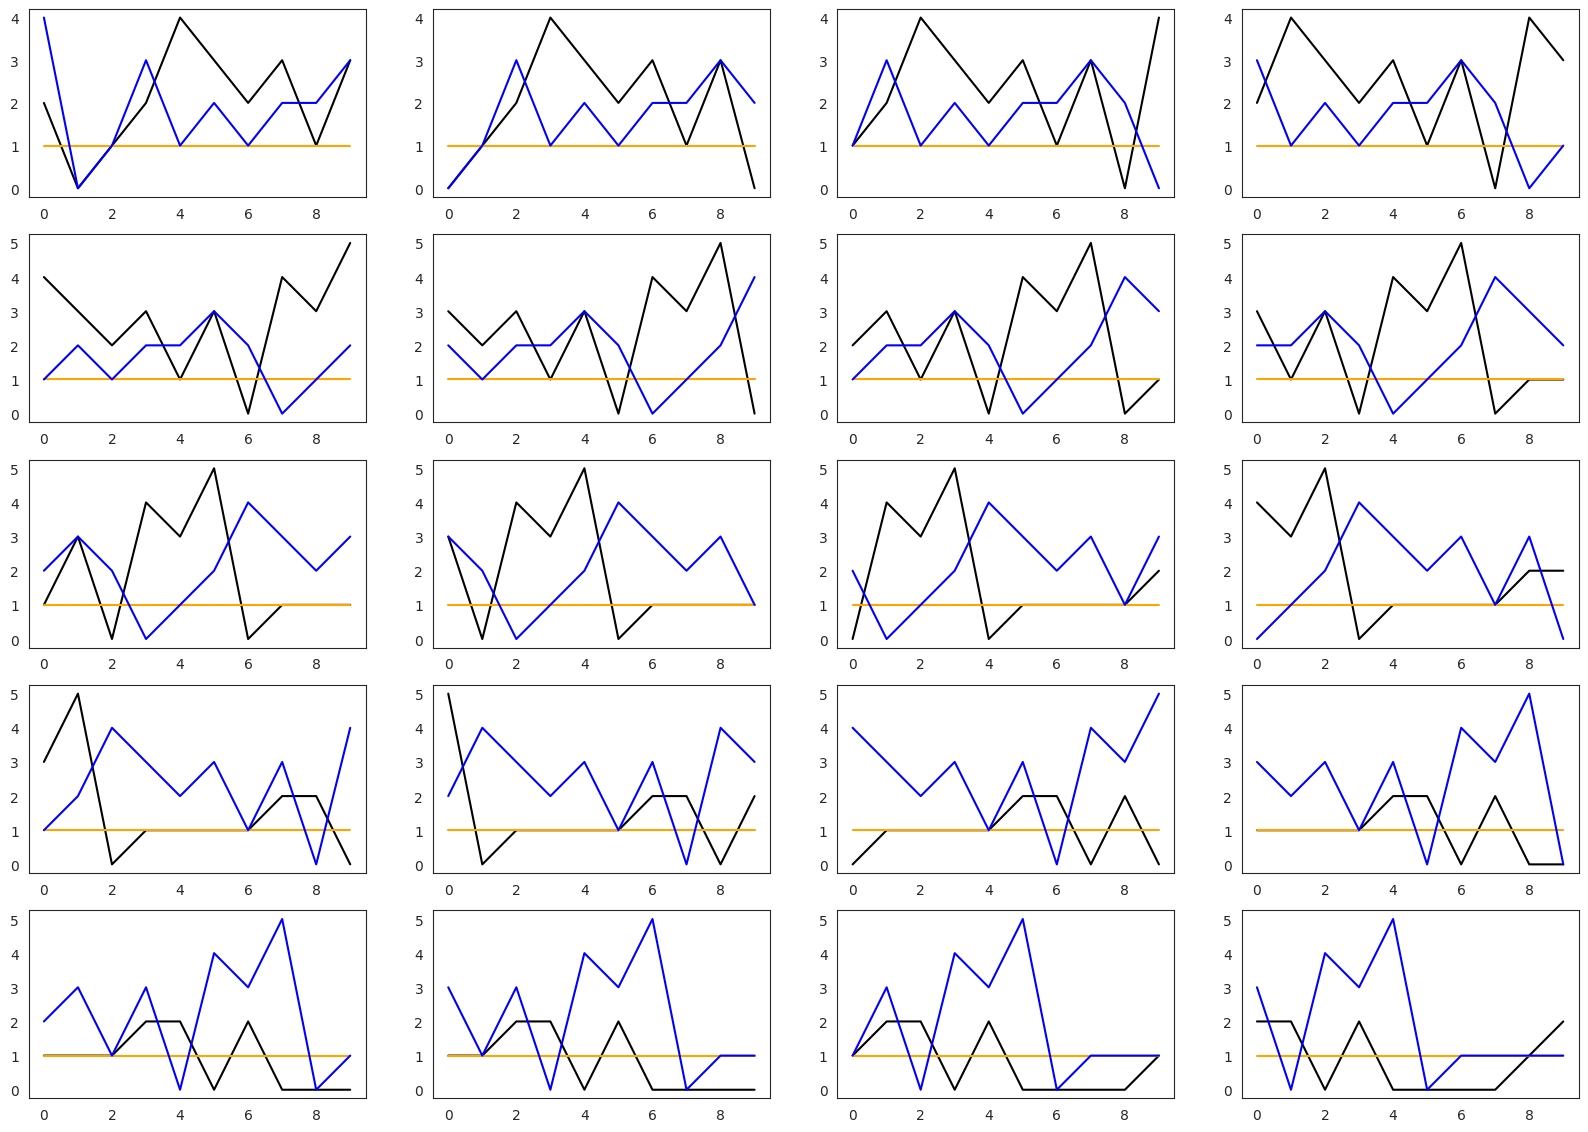

In [255]:
import seaborn as sns
plt.figure(figsize=(20, 20))
for id in range(0,20):
    plt.subplot(7,4,id+1)
    df_test=pd.DataFrame(y_test1[id])
    df_pred=pd.DataFrame(y_pred1[id].astype(int))
    df_bas_pred=pd.DataFrame(y_bas_pred1[id])
    plt.plot(df_test[0],c='black',label='test set')
    plt.plot(df_pred[0],c='orange',label='lstm prediction')
    plt.plot(df_bas_pred[0],c='blue',label='baseline prediction')
plt.show()

In [240]:
X=test_data_max_square.tail(10)
model.predict(X)

2022-12-09 10:08:18.486502: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_239/lstm_206/PartitionedCall]] [Op:__inference_predict_function_1059520]